## **第二屆深度學習與電腦視覺馬拉松：期末專題**

專題內容：利用YOLOv3訓練一個可以偵測圖片中口罩的模型

圖片資料來源：https://drive.google.com/file/d/1HMyrmJajwgJCmm2Rhk_sh6JRnvObrFgB/view?fbclid=IwAR3mCGCLE8hT3lwVOIwpGbrwC82krpEJ73IvwahtCBOMe0-RF-sKzlvLwbw

(由伊甸基金會所屬的數位資料處理庇護工場所標記、免費開源釋出)

圖片張數：682張

圖片標注格式：PASCAL VOC(其中good類別代表『有帶好口罩』，也是這次專題會使用的類別)

In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 11.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd '/content/gdrive/My Drive/final_project'
#!git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/final_project
/content/gdrive/My Drive/final_project/keras-yolo3


In [6]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [0]:
from PIL import Image
if not os.path.exists("train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    # 資料類別
    classes = ['good']
    
    # 把資料及分成train和val
    data_sets = ['train', 'val']

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(data_path, list_file):
        in_file = open(data_path)
        tree = ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
    
    # 紀錄class_id，基本上只有一類good
    class_txt = open('class.txt', 'w')
    for class_id in classes: 
        class_txt.write('%s' %(class_id))
        class_txt.write('\n')
    class_txt.close()

    # 圖片和label位置
    image_dir = 'mask_data'
    annotation_path = 'mask_label'
    images_name = [image.split('.')[0] for image in os.listdir(image_dir)]

    for data_set in data_sets:
        print('Now processing ' + data_set)
        list_file = open('%s.txt' % data_set , 'w')

        # os.listdir() 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。
        annots = os.listdir(annotation_path)
        

        # 有些情況會造成程式出錯(ex.label裡的圖片名稱沒在資料裡，或是檔案名稱中有space)
        # 處理這些情況
        new_annots = []
        for file_name in annots: 
            name = file_name.split('.')[0]
            if name not in images_name:
                print(name + ' not in pictures.')
                continue
            if ' ' in name:
                print(name + ' including space')
                continue
            new_annots.append(file_name)
        annots = new_annots

        # 取0.9的比例當作validation
        annot_len = len(annots)
        split_num = int(annot_len * 0.9)

        # 前0.9當作training, 剩餘當作validation
        if data_set == 'train':
            data = annots[:split_num]
        else:
            data = annots[split_num:]
        
        # 將xml格式標注轉換成txt，這是為了讓YOLO能讀懂
        for file_name in data: 
            name = file_name.split('.')[0]               
            list_file.write(os.path.join(image_dir, '%s.jpg' % name))
            # 將對應的xml裡面的bounding box資訊寫到txt檔案裡面
            convert_annotation(os.path.join(annotation_path , file_name), list_file)
            list_file.write('\n')
                
        list_file.close()    
  

In [0]:
# 圖片裡有各種格式如png, jpeg等，這樣會造成讀取問題(label裡面統一jpg)
# 圖片如果不是jpg強制轉成jpg
def to_jpg(image_name):
    if image_name.split('.')[-1] != 'jpg':
        im = Image.open(image_name) 
        try:
            im.save(image_name.split('.')[0] + '.jpg')
        except:
            im = im.convert('RGB')     
            im.save(image_name.split('.')[0] + '.jpg')

images = os.listdir(image_dir)
for single_image in images:
    image = image_dir + '/' + single_image
    to_jpg(image)

In [4]:
# 載入套件
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [0]:
# convert.py '-w' : 代表只轉換權重 weights 到 model_data/yolo_weights.h5
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
# 檔案路徑資訊
annotation_path_train = 'train.txt' # 轉換好格式的 train 標註檔案
annotation_path_val = 'val.txt' # 轉換好格式的 val 標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

In [0]:
# 以下開始進行YOLO的訓練
is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
with open(annotation_path_train) as f:
    train_lines = f.readlines()
with open(annotation_path_val) as f:
    val_lines = f.readlines()

np.random.seed(10101)
np.random.shuffle(train_lines)
np.random.shuffle(val_lines)
np.random.seed(None)

num_val = len(val_lines)
num_train = len(train_lines)

print('train number : ', num_train)
print('val number : ', num_val)

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
# freeze的含義就是將該模型的圖結構和該模型的權重固化到一起了.也即加載freeze的模型之后,立刻能夠使用了。
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    freeze_hist = model.fit_generator(data_generator_wrapper(train_lines , batch_size, input_shape, anchors, num_classes),
            # steps_per_epoch is used to generate the entire dataset once by calling the generator steps_per_epoch times
            # https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(val_lines , batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=80,
            initial_epoch=0,
            callbacks=[logging, checkpoint , reduce_lr , early_stopping])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 8 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    unfreeze_hist = model.fit_generator(data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(val_lines, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')    

In [9]:
# 讀取訓練好的模型權重
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)













logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(416, 416, 3)
Found 5 boxes for img
good 0.35 (327, 74) (363, 122)
good 0.45 (462, 61) (496, 109)
good 0.76 (584, 83) (614, 128)
good 0.94 (201, 74) (233, 113)
good 0.95 (58, 72) (90, 118)
0.08258228900001541


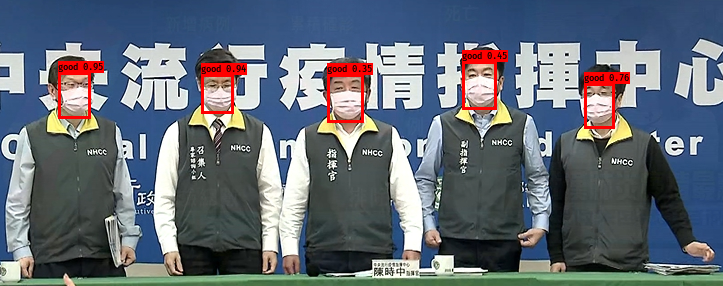

In [12]:
# 測試最後結果，我們從網路上抓一些圖片進行測試
r_image = yolo_model.detect_image(Image.open('mask_test/test_2.jpg'))
r_image

(416, 416, 3)
Found 3 boxes for img
good 0.57 (327, 158) (445, 300)
good 0.58 (8, 193) (141, 361)
good 0.95 (644, 297) (775, 413)
0.12297498899999937


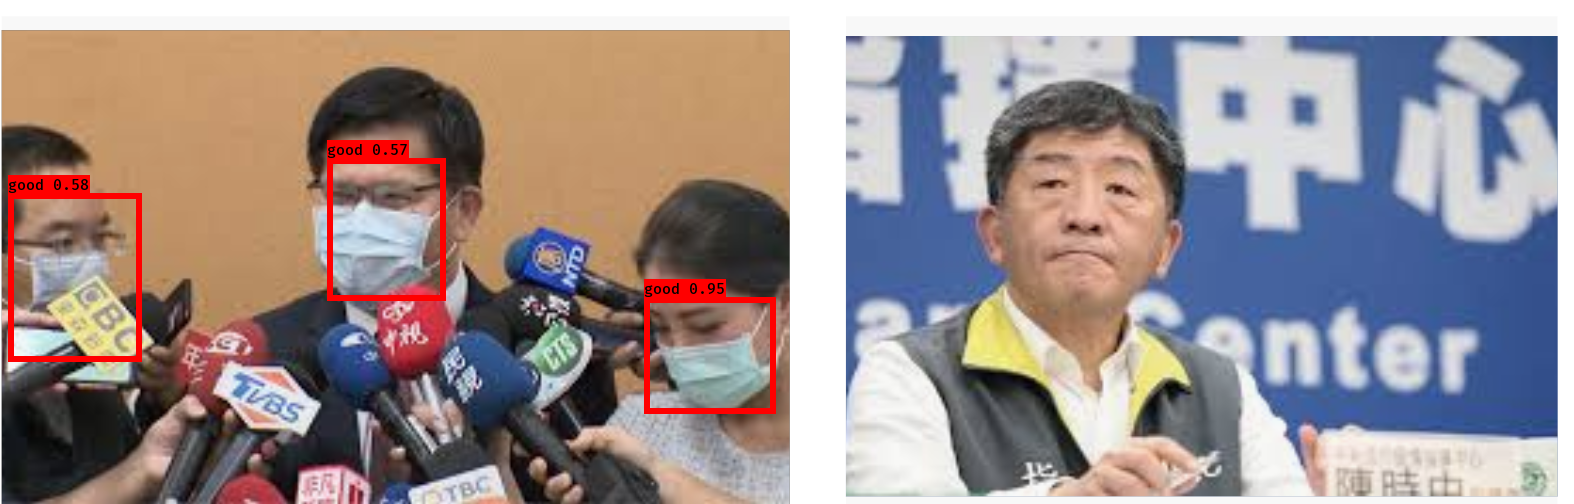

In [13]:
# 沒戴口罩的人也能認出
r_image = yolo_model.detect_image(Image.open('mask_test/test_3.png'))
r_image